In [1]:
import os
import math
import pandas as pd
import numpy as np
import umap
from functools import reduce
from sklearn.preprocessing import StandardScaler

# Configuration settings
from chasm.config import CONFIG

# PLINK preprocessing utilities
from chasm.plink_preprocessing import (
    concat_AFs, 
    divide_into_chunks, 
    make_ids,
    make_AFs
)

from chasm.data_preprocessing import (
    is_snp,
    make_df,
    calculate_AFs,
    merge_AFs_ensembl_build,
    divide_into_chunks,
    align_dataframes,
)
from chasm.gwas import ols_regression, pca_of_n_snps, project_on_dimensions

from chasm.visualization import make_population_plot, plot_training_history
from chasm.ld_blocks import segmenter
from chasm.abyss import linear_abyss, AE, decoder

from chasm.fst import make_fst, make_global_fst
from chasm.cluster import silhouette_score_clusters

2025-02-26 10:04:49.145820: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 10:04:49.242055: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 10:04:50.243178: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 10:04:50.246444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-26 10:04:52.234874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Changing the GTM data into a pickle file having an id file and calculating the AFs for each SNP 
# with the CHROM:POS for every corresponding RSID

# GTM data
"""
path_data_raw = f"{CONFIG['PATH_data']}/00_raw/recoded_1000G.raw"
path_raw = f"{CONFIG['PATH_data']}/01_raw/"
path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"

geno = make_df(path_data_raw, path_usefull, path_raw)

afs = calculate_AFs(geno)

path_ensembl = f"/mnt/e/1000G_data/usefull/ensembl_build"
merge_AFs_ensembl_build(path_ensembl, path_usefull, afs)
"""
# Divide the AFs into chunks
"""
size_chunck = 20_000
min_maf = 0.01

path_raw = f"{CONFIG['PATH_data']}/01_raw/geno.pkl"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_output = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

divide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)
"""

'\nsize_chunck = 20_000\nmin_maf = 0.01\n\npath_raw = f"{CONFIG[\'PATH_data\']}/01_raw/geno.pkl"\npath_afs = f"{CONFIG[\'PATH_data\']}/02_usefull/allele_frequencies.pkl"\npath_output = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\n\ndivide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)\n'

# Choose SNPs to project on n dimensions

# Observe raw dimensions

In [13]:
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/00_raw/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
ids = ids.merge(labels, left_on="IID", right_on="Sample name")

Running iteration 2
The optimal number of clusters is: 5


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


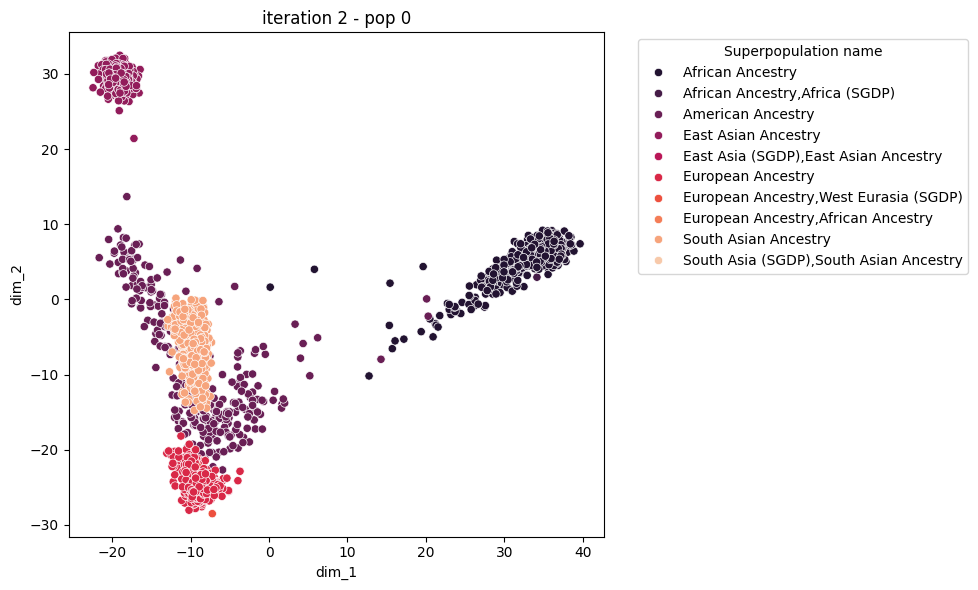

Running iteration 3


In [ ]:
path_macro_similar = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
iterations = 3

for iter in list(range(iterations)):
    iter += 2
    print(f"Running iteration {iter}")
    path_output = f"{CONFIG['PATH_data']}/iteration_{iter}/"
    
    if iter == 2:
        ids[f"cluster_{iter}"] = f"{0}"
        os.makedirs(f"{path_output}/pop_{0}", exist_ok=True)
        ids.to_pickle(f"{path_output}/pop_{0}/ids.pkl")
        
    else:
        pass
    
    cluster_to_add = []
    for sub_pop in ids[f"cluster_{iter}"].unique():
        path_output = f"{CONFIG['PATH_data']}/iteration_{iter}/pop_{sub_pop}/"
        os.makedirs(path_output, exist_ok=True)
        temp_ids = ids[ids[f"cluster_{iter}"] == sub_pop]
        nr_of_projected_dimensions = 3
        geno = project_on_dimensions(path_macro_similar, path_output, temp_ids, nr_of_projected_dimensions=3, nr_snps = 20_000, n_components = 10)
        
        existing_dims = []   
        for PCs in [f for f in os.listdir(path_output) if f.startswith('PCs')]:
            dim = PCs.split('PCs_')[1].split('.pkl')[0]
            path_PC = f"{path_output}/{PCs}"
            PCs = pd.read_pickle(f"{path_PC}")
            temp_ids = temp_ids.copy()
            temp_ids[dim] = list(PCs['PC1'])
            existing_dims.append(dim)
        labels = silhouette_score_clusters(temp_ids, existing_dims, plot=False)
        for element in labels:
            cluster_to_add.append(f"{sub_pop}_{element}")
            
    ids[f"cluster_{iter+1}"] = cluster_to_add
    ids.to_pickle(f"{CONFIG['PATH_data']}/iteration_{iter}/ids.pkl")
    
    # Vizualization
    path_input = f"{CONFIG['PATH_data']}/iteration_{iter}/"
    for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        temp_ids = ids[ids[f"cluster_{iter}"] == pop]
        path_pop = f"{path_input}/pop_{pop}"
        for PCs in [f for f in os.listdir(path_pop) if f.startswith('PCs')]:
            dim = PCs.split('PCs_')[1].split('.pkl')[0]
            path_PC = f"{path_pop}/{PCs}"
            PCs = pd.read_pickle(f"{path_PC}")
            temp_ids = temp_ids.copy()
            temp_ids[dim] = list(PCs['PC1'])
        if len(list(temp_ids['Population name'].unique())) > 20:
            make_population_plot(temp_ids, 'dim_1', 'dim_2', 'Superpopulation name', f"iteration {iter} - pop {pop}", palette = 'rocket')
        else:
            make_population_plot(temp_ids, 'dim_1', 'dim_2', 'Population name', f"iteration {iter} - pop {pop}", palette = 'rocket')


# Find the dims per snp

In [4]:
"""
path_data = f"{CONFIG['PATH_data']}/"
iteration_files = [f for f in os.listdir(path_data) if f.startswith('iteration')]
snp_ids_dfs = []
for iteration in iteration_files:
    path_iteration = f"{path_data}/{iteration}/"
    for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        path_snp_ids = f"{path_iteration}/pop_{pop}/snp_ids.pkl"
        snp_ids = pd.read_pickle(path_snp_ids)
        snp_ids = snp_ids.drop(columns=['pval', 'betas', '-logp'])
        snp_ids[f"{iteration}_pop_{pop}_dim"] = list(snp_ids['dim'])
        snp_ids = snp_ids.drop(columns=['dim'])
        snp_ids = snp_ids.sort_index()  # Now sort
        snp_ids_dfs.append(snp_ids)
        
snp_ids = reduce(lambda left, right: pd.merge(left, right, on='snp_rs'), snp_ids_dfs)
snp_ids.to_pickle(f"{CONFIG['PATH_data']}/02_usefull/post_iterations_snp_ids.pkl")
"""

'\npath_data = f"{CONFIG[\'PATH_data\']}/"\niteration_files = [f for f in os.listdir(path_data) if f.startswith(\'iteration\')]\nsnp_ids_dfs = []\nfor iteration in iteration_files:\n    path_iteration = f"{path_data}/{iteration}/"\n    for pop in [f for f in os.listdir(path_iteration) if f.startswith(\'pop\')]:\n        pop = pop.split(\'pop_\')[1]\n        path_snp_ids = f"{path_iteration}/pop_{pop}/snp_ids.pkl"\n        snp_ids = pd.read_pickle(path_snp_ids)\n        snp_ids = snp_ids.drop(columns=[\'pval\', \'betas\', \'-logp\'])\n        snp_ids[f"{iteration}_pop_{pop}_dim"] = list(snp_ids[\'dim\'])\n        snp_ids = snp_ids.drop(columns=[\'dim\'])\n        snp_ids = snp_ids.sort_index()  # Now sort\n        snp_ids_dfs.append(snp_ids)\n        \nsnp_ids = reduce(lambda left, right: pd.merge(left, right, on=\'snp_rs\'), snp_ids_dfs)\nsnp_ids.to_pickle(f"{CONFIG[\'PATH_data\']}/02_usefull/post_iterations_snp_ids.pkl")\n'

# Make autoencoder

In [5]:
# create one dimensional representation of the data

In [6]:
"""
path_data = f"{CONFIG['PATH_data']}/"
iterations = [f for f in os.listdir(path_data) if f.startswith('iteration_0')]
for iteration in iterations:
    path_iteration = f"{path_data}/{iteration}/"
    for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        path_pop = f"{path_iteration}/pop_{pop}/"
        dims = [f for f in os.listdir(path_pop) if f.startswith('PCs')]

nr_PCs = 3
PCs_labels = []
for i in range(nr_PCs):
    PCs_labels.append(f"PC{i+1}")

dims_df = pd.DataFrame()
for dim  in dims:
    path_dim = f"{path_pop}/{dim}"
    dim = dim.split('PCs_')[1].split('.pkl')[0]
    
    PCs = pd.read_pickle(path_dim)
    for label in PCs_labels:
        PCs.rename(columns={f"{label}": f"{label}_dim_{dim}"}, inplace=True)
        dims_df[f"{label}_{dim}"] = list(PCs[f"{label}_dim_{dim}"])
    

hidden = 2
epoch = 500
patience = 10
[autoencoder, bottleneck_model, history] = AE(dims_df, 1, dims_df.shape[1]*2, epoch, patience)

bottle = bottleneck_model(dims_df.to_numpy())
bottleneck_df = pd.DataFrame(bottle, columns=['Bottleneck_1D'])

ids = pd.read_pickle(f"{CONFIG['PATH_data']}/02_usefull/ids.pkl")
ids['center_dim'] = list(bottleneck_df['Bottleneck_1D'])
ids.to_pickle(f"{CONFIG['PATH_data']}/02_usefull/ids_with_center_dim.pkl")
make_population_plot(ids, 'center_dim', 'center_dim', 'FID', f"show IDs", palette = 'rocket')
"""

'\npath_data = f"{CONFIG[\'PATH_data\']}/"\niterations = [f for f in os.listdir(path_data) if f.startswith(\'iteration_0\')]\nfor iteration in iterations:\n    path_iteration = f"{path_data}/{iteration}/"\n    for pop in [f for f in os.listdir(path_iteration) if f.startswith(\'pop\')]:\n        pop = pop.split(\'pop_\')[1]\n        path_pop = f"{path_iteration}/pop_{pop}/"\n        dims = [f for f in os.listdir(path_pop) if f.startswith(\'PCs\')]\n\nnr_PCs = 3\nPCs_labels = []\nfor i in range(nr_PCs):\n    PCs_labels.append(f"PC{i+1}")\n\ndims_df = pd.DataFrame()\nfor dim  in dims:\n    path_dim = f"{path_pop}/{dim}"\n    dim = dim.split(\'PCs_\')[1].split(\'.pkl\')[0]\n    \n    PCs = pd.read_pickle(path_dim)\n    for label in PCs_labels:\n        PCs.rename(columns={f"{label}": f"{label}_dim_{dim}"}, inplace=True)\n        dims_df[f"{label}_{dim}"] = list(PCs[f"{label}_dim_{dim}"])\n    \n\nhidden = 2\nepoch = 500\npatience = 10\n[autoencoder, bottleneck_model, history] = AE(dims_df,

In [7]:
# Use lower dimensional representation to create AF probabilities

In [8]:
central_dim = pd.read_pickle(f"{CONFIG['PATH_data']}/02_usefull/ids_with_center_dim.pkl")

In [9]:
chroms = [f for f in os.listdir(f"{CONFIG['PATH_data']}/03_macro_similar_AF") if f.startswith('chrom')]
for chrom in chroms:
    path_chrom = f"{CONFIG['PATH_data']}/03_macro_similar_AF/{chrom}"
    chunks = [f for f in os.listdir(path_chrom) if f.startswith('chunk')]
    for chunk in chunks:
        path_chunk = f"{path_chrom}/{chunk}"

In [10]:
chunk = pd.read_pickle(path_chunk)

In [11]:
chunk

,rs9615890_A,rs470018_C,rs5757569_A,rs9613304_T,rs5754915_A,rs134178_G,rs3869874_C,rs165912_C,rs2012540_G,rs738818_A,...,rs73177074_T,rs2013215_C,rs113570940_C,rs377221550_T,rs6004890_G,rs3984495_A,rs4145503_G,rs117767918_A,rs12167043_A,rs12172606_C
0,0,-1,1,0,-1,0,-1,1,-1,0,...,1,1,1.0,1,-1,1,1,0,1,1
1,0,0,0,0,0,-1,-1,1,0,-1,...,0,1,1.0,1,0,1,1,1,0,1
2,0,1,-1,0,1,-1,1,0,0,0,...,1,1,1.0,1,1,0,1,1,1,1
3,0,1,-1,1,0,0,-1,0,-1,-1,...,1,1,1.0,1,1,1,1,0,1,1
4,-1,0,-1,0,1,-1,0,-1,-1,-1,...,1,1,1.0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,-1,-1,0,1,-1,1,0,-1,0,1,...,1,0,1.0,1,1,1,1,1,0,1
2500,-1,0,0,1,-1,0,1,0,0,0,...,1,1,1.0,1,1,1,1,1,0,1
2501,0,-1,-1,1,0,0,-1,0,1,0,...,1,1,1.0,1,1,1,1,1,1,1
2502,0,0,0,-1,0,0,0,1,0,0,...,1,1,1.0,1,1,1,1,1,1,1


In [ ]:
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]

['00_raw',
 '02_usefull',
 '01_raw',
 '03_macro_similar_AF',
 'iteration_0',
 'iteration_1',
 'iteration_2']

In [ ]:
# 1
# central-chunk
# 2
# central-dim_it_0 + dim_it_0-chunk
# metamodel(central-dim_it_0 + dim_it_0-chunk)
# 3
# central-dim_it_0 + dim_it_0-dim_it_1 + dim_it_1-chunk
# metamodel(central-dim_it_0 + dim_it_0-dim_it_1 + dim_it_1-chunk)
# 4


In [46]:
decoder0, decoder0_history =  decoder(central_dim[['center_dim']], chunk, 1, 100, 10)

Test Loss: 0.4043, Test MAE: 0.4957


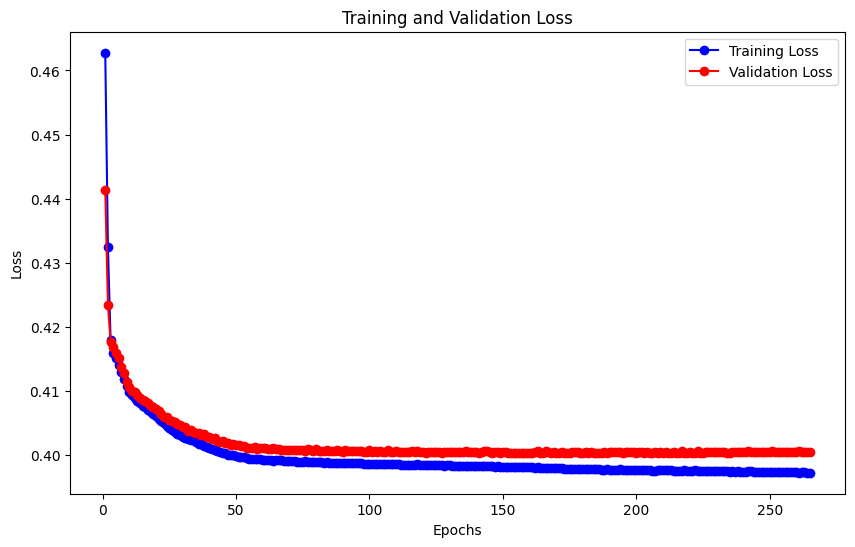

In [ ]:
# Call the plotting function
plot_training_history(decoder0_history)


In [71]:
first_output = decoder0.predict(central_dim[['center_dim']].to_numpy())

79/79 [==============================] - 0s 1ms/step


In [72]:
first_output

array([[ 0.24080166, -0.08128047, -0.13828506, ...,  0.8367161 ,
         0.8596971 ,  0.84175   ],
       [-0.07307991, -0.1188411 , -0.11011967, ...,  0.90755385,
         0.87180114,  0.9070927 ],
       [ 0.34354752, -0.06867485, -0.14733961, ...,  0.81387407,
         0.85603344,  0.8205463 ],
       ...,
       [-0.1017352 , -0.12042259, -0.10518934, ...,  0.91458935,
         0.87381184,  0.9133135 ],
       [-0.09154186, -0.12051181, -0.10808305, ...,  0.9122803 ,
         0.87288177,  0.9112802 ],
       [-0.078088  , -0.11930791, -0.10959221, ...,  0.90882355,
         0.8720771 ,  0.9082135 ]], dtype=float32)

# first iteration

In [101]:
path_data = f"{CONFIG['PATH_data']}/"
nr_it = 0
iteration = [f for f in os.listdir(path_data) if f.startswith(f"iteration_{nr_it}")][0]
path_iteration = f"{path_data}/{iteration}/"
ids = pd.read_pickle(f"{path_iteration}/ids.pkl")
dims_dfs = []
for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
    pop = pop.split('pop_')[1]
    temp_ids = ids[ids[f"cluster_{iteration.split('_')[1]}"] == pop]
    path_pop = f"{path_iteration}/pop_{pop}/"
    dims = [f for f in os.listdir(path_pop) if f.startswith('PCs')]
    
    nr_PCs = 3
    PCs_labels = []
    for i in range(nr_PCs):
        PCs_labels.append(f"PC{i+1}")

    dims_df = pd.DataFrame()
    for dim  in dims:
        path_dim = f"{path_pop}/{dim}"
        dim = dim.split('PCs_')[1].split('.pkl')[0]
        
        PCs = pd.read_pickle(path_dim)
        for label in PCs_labels:
            PCs.rename(columns={f"{label}": f"pop_{pop}_{label}_dim_{dim}"}, inplace=True)
            dims_df[f"pop_{pop}_{label}_dim_{dim}"] = list(PCs[f"pop_{pop}_{label}_dim_{dim}"])
    dims_df.index = temp_ids.index
    dims_dfs.append(dims_df)
        

# Concatenate DataFrames, filling missing columns with NaN
dims_dfs = pd.concat(dims_dfs, ignore_index=False, sort=True)
dims_dfs_2 = dims_dfs.fillna(0)

In [ ]:
decoder1_in, decoder1_in_history =  decoder(central_dim[['center_dim']], dims_dfs_2, 1, 1000, 10)

Test Loss: 65.7184, Test MAE: 5.4831


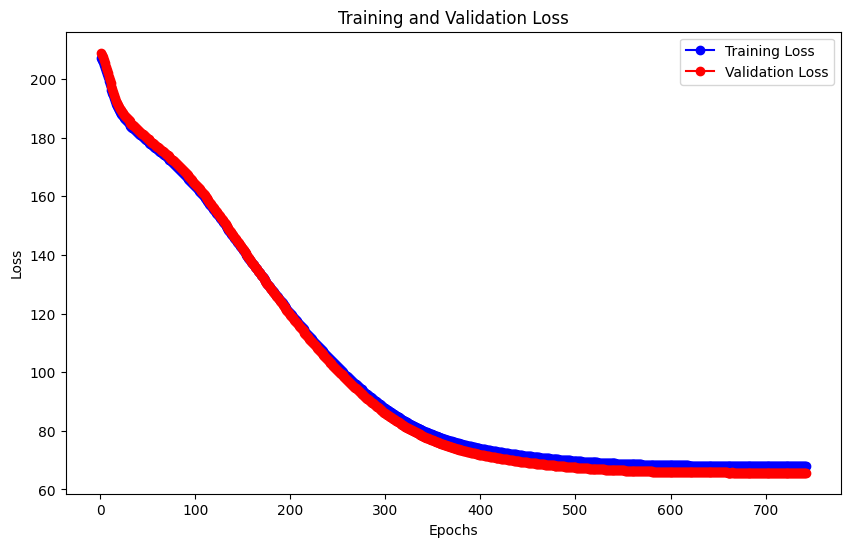

In [61]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    
    # Extract loss values
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)  # Use get() in case val_loss is missing
    
    epochs = range(1, len(loss) + 1)

    # Plot Training Loss
    plt.plot(epochs, loss, 'bo-', label='Training Loss')

    # Plot Validation Loss if available
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the plotting function
plot_training_history(decoder1_in_history)


In [ ]:
decoder1_in, decoder1_in_history =  decoder(central_dim[['center_dim']], dims_dfs_2, 1, 1000, 10)
decoder2_in, decoder2_in_history =  decoder(dims_dfs_2, chunk, 1, 1000, 10)


Test Loss: 0.4045, Test MAE: 0.5003


In [63]:
from keras.models import Model
from keras.layers import Input

def create_meta_decoder(decoder1, decoder2):
    # Step 1: Define the input based on decoder1's input shape
    input_layer = Input(shape=(decoder1.input_shape[1],))

    # Step 2: Pass through the first decoder
    x = decoder1(input_layer)

    # Step 3: Pass through the second decoder
    output_layer = decoder2(x)

    # Step 4: Create the combined model
    meta_decoder = Model(inputs=input_layer, outputs=output_layer)

    return meta_decoder


In [64]:
# Create the meta-decoder
meta_decoder = create_meta_decoder(decoder1_in, decoder2_in)

# Ensure all layers are trainable
for layer in meta_decoder.layers:
    layer.trainable = True

# Compile the meta-decoder
meta_decoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Check structure and number of trainable parameters
meta_decoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 model_8 (Functional)        (None, 9)                 64        
                                                                 
 model_9 (Functional)        (None, 507)               133893    
                                                                 
Total params: 133957 (523.27 KB)
Trainable params: 133957 (523.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
history = meta_decoder.fit(
    central_dim[['center_dim']].to_numpy(), 
    chunk.to_numpy(), 
    epochs=1000, 
    validation_split=0.2, 
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)],
    verbose=0
)

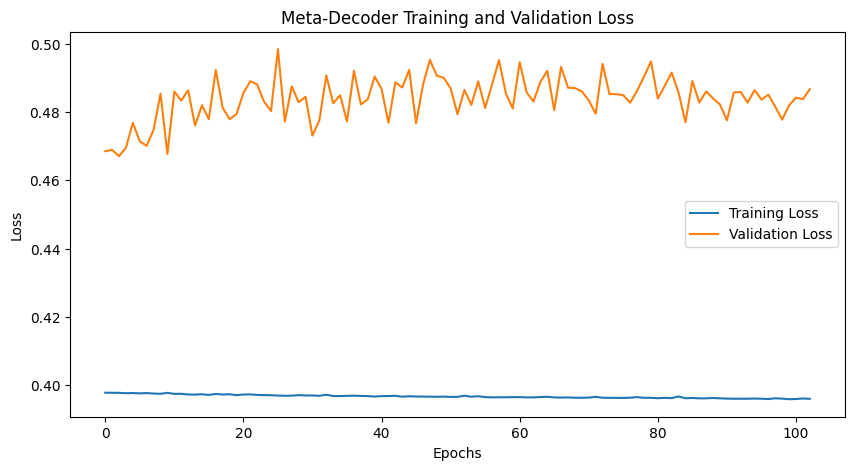

In [68]:
import matplotlib.pyplot as plt

# Plot loss during fine-tuning
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Meta-Decoder Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [69]:
meta_output = meta_decoder.predict(central_dim[['center_dim']].to_numpy())


79/79 [==============================] - 0s 2ms/step


In [77]:
meta_output = pd.DataFrame(meta_output, columns=chunk.columns)
first_output = pd.DataFrame(first_output, columns=chunk.columns)

In [87]:
col_test = list(chunk.columns)[-1]

In [91]:
test1 = first_output[[col_test]]
test1['pop'] = list(ids['FID'])
test1['humans'] = list(central_dim['center_dim'])
test2 = meta_output[[col_test]]
test2['pop'] = list(ids['FID'])
test2['humans'] = list(central_dim['center_dim'])

/tmp/ipykernel_4824/1078557130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['pop'] = list(ids['FID'])
/tmp/ipykernel_4824/1078557130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['humans'] = list(central_dim['center_dim'])
/tmp/ipykernel_4824/1078557130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

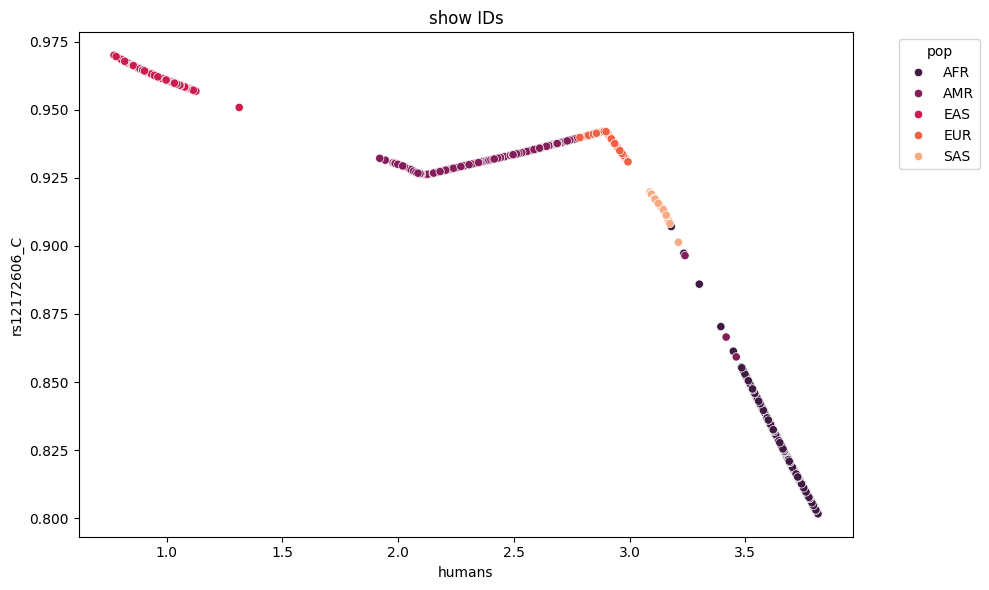

In [93]:
make_population_plot(test1, 'humans', col_test,'pop', f"show IDs", palette = 'rocket')

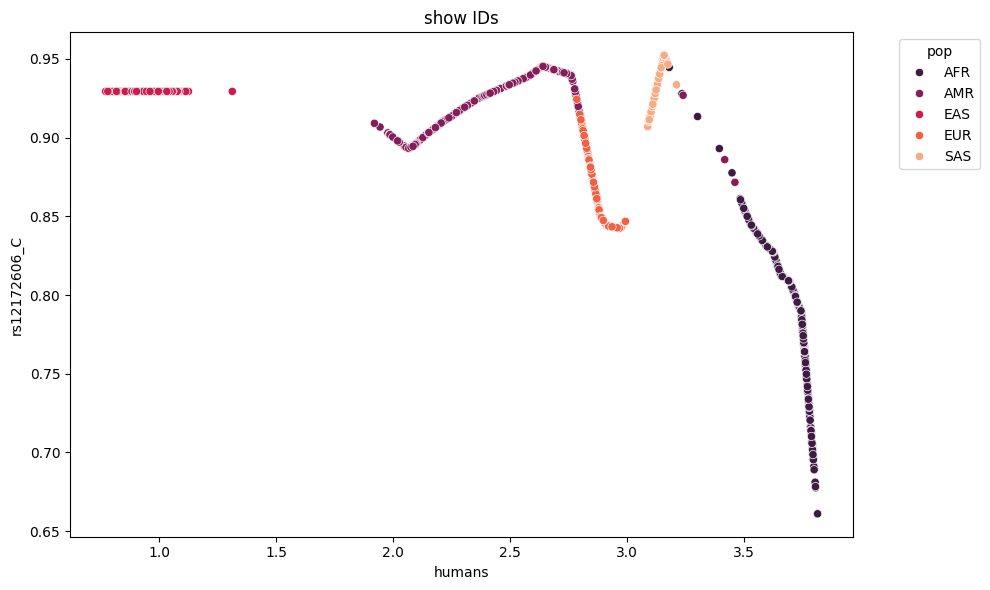

In [94]:
make_population_plot(test2, 'humans', col_test,'pop', f"show IDs", palette = 'rocket')


In [95]:
# Iteration 2

In [ ]:
path_data = f"{CONFIG['PATH_data']}/"
nr_it = 1
iteration = [f for f in os.listdir(path_data) if f.startswith(f"iteration_{nr_it}")][0]
path_iteration = f"{path_data}/{iteration}/"
ids = pd.read_pickle(f"{path_iteration}/ids.pkl")
dims_dfs = []
for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
    pop = pop.split('pop_')[1]
    temp_ids = ids[ids[f"cluster_{iteration.split('_')[1]}"] == pop]
    path_pop = f"{path_iteration}/pop_{pop}/"
    dims = [f for f in os.listdir(path_pop) if f.startswith('PCs')]
    
    nr_PCs = 3
    PCs_labels = []
    for i in range(nr_PCs):
        PCs_labels.append(f"PC{i+1}")

    dims_df = pd.DataFrame()
    for dim  in dims:
        path_dim = f"{path_pop}/{dim}"
        dim = dim.split('PCs_')[1].split('.pkl')[0]
        
        PCs = pd.read_pickle(path_dim)
        for label in PCs_labels:
            PCs.rename(columns={f"{label}": f"pop_{pop}_{label}_dim_{dim}"}, inplace=True)
            dims_df[f"pop_{pop}_{label}_dim_{dim}"] = list(PCs[f"pop_{pop}_{label}_dim_{dim}"])
    dims_df.index = temp_ids.index
    dims_dfs.append(dims_df)
        

# Concatenate DataFrames, filling missing columns with NaN
dims_dfs = pd.concat(dims_dfs, ignore_index=False, sort=True)
dims_dfs = dims_dfs.fillna(0)

In [ ]:

dims_dfs

,pop_0_0_PC1_dim_dim_1,pop_0_0_PC1_dim_dim_2,pop_0_0_PC1_dim_dim_3,pop_0_0_PC2_dim_dim_1,pop_0_0_PC2_dim_dim_2,pop_0_0_PC2_dim_dim_3,pop_0_0_PC3_dim_dim_1,pop_0_0_PC3_dim_dim_2,pop_0_0_PC3_dim_dim_3,pop_0_1_PC1_dim_dim_1,...,pop_0_3_PC3_dim_dim_3,pop_0_4_PC1_dim_dim_1,pop_0_4_PC1_dim_dim_2,pop_0_4_PC1_dim_dim_3,pop_0_4_PC2_dim_dim_1,pop_0_4_PC2_dim_dim_2,pop_0_4_PC2_dim_dim_3,pop_0_4_PC3_dim_dim_1,pop_0_4_PC3_dim_dim_2,pop_0_4_PC3_dim_dim_3
0,0.933013,-4.068720,10.336285,-3.492381,9.887428,-2.532068,9.639750,2.783962,7.823999,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.188379,-4.959371,16.235042,-2.123308,21.497266,3.080950,20.465567,0.438365,-1.994241,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.393187,-6.371439,-3.397163,-6.866763,-3.048944,6.415818,1.044204,2.575572,-2.637278,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.743959,-6.591337,7.333168,-6.852792,8.612897,-1.655533,8.877612,-0.498862,-0.818207,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.883044,-5.209089,2.450627,-4.378275,1.098689,2.820204,-2.990109,-2.853764,-3.851209,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.935759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.250069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.184803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.753146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
